# 📄 Step 1: Simulate the Telnet connection before Document Collection starts.

## 📁 Part 1: Load Required Libraries

### 📦 Import Required Libraries

We begin by importing the necessary libraries for data handling, visualization, time delay, and database connectivity:

- **`pandas`**: for reading and managing tabular data.
- **`matplotlib.pyplot`**: for plotting the robot axis readings.
- **`time`** and **`os`**: to simulate real-time behavior and file checks.
- **`psycopg2`**: for connecting to the Neon PostgreSQL database.
- **`IPython.display`**: to update visualizations in-place during streaming.

In [476]:
# Part 1 - Load Required Libraries

# Import Required Libraries
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
import os
import sqlalchemy 
from dateutil import parser
from datetime import datetime

from sqlalchemy import create_engine
from urllib.parse import quote_plus

# 🔐 Neon DB Config - Mostafa's db
DB_CONFIG = {
    "host": "ep-spring-surf-adwzqkg9-pooler.c-2.us-east-1.aws.neon.tech",
    "database": "neondb",
    "user": "neondb_owner",
    "password": "npg_2DdhmHi4GxFp",
    "port": "5432",
    "sslmode": "require",
}

## 📊 Part 2: Define the Streaming Simulator Class

### 🧰 Define the `StreamingSimulator` Class

We define a custom class `StreamingSimulator` that:
- Loads the robot performance data from a CSV file.
- Creates a table in the database (if it doesn’t already exist).
- Simulates streaming by processing one record every few seconds.
- Plots the axis readings dynamically.
- Inserts each record into a Neon PostgreSQL database.

This class encapsulates both the streaming logic and data ingestion into the database.

## 🗄️ OPTIONAL Part 3: Create the Database Table

### 🗄️ Delete and Create table

Not invoked in the current code, but if it is,  the first call to the database, the simulator:
- Establishes a connection to the Neon Postgres database.
- Drops the `robot_readings` table if it already exists
- Executes a `CREATE TABLE` statement for `robot_readings`.
- Defines the columns as `Axis #1` through `Axis #8` with type `REAL` (floating point).

This ensures the database schema matches the CSV structure before streaming starts.

In [ ]:
# Part 2 - Define the StreamingSimulator class
# This class encapsulates both the streaming logic and data ingestion into the database.

#defining a custom class `StreamingSimulator`
class StreamingSimulator:

    # Init funtion gets called once when an object of the class is created
    def __init__(self, csv_path, delay=2):
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"❌ File not found: {csv_path}")

        #Loads the robot performance data from a CSV file.
        self.data = pd.read_csv(csv_path)

        self.delay = delay
        self.index = 0
        # self.columns = [col for col in self.data.columns if "Axis" in col]
        # self.columns = [col for col in self.data.columns if "Trait" not in col and "Time" not in col]
        self.columns = [col for col in self.data.columns if "Trait" not in col]
        self.history = pd.DataFrame(columns=self.columns)
        print(f"✅ Loaded {len(self.data)} rows from {csv_path}")

        self._drop_and_create_table()

    def convert_to_timestamptz(timestamp_str: str) -> datetime:
        try:
            # Split the string to separate the datetime part from the timezone part
            dt_part, tz_part = timestamp_str.split('+')
            
            # Manually reconstruct the timezone string to be compatible with pytz
            tz_str = f'+{tz_part}'
            
            # Parse the datetime part of the string
            dt_naive = datetime.strptime(dt_part.strip(), "%Y-%m-%d %H:%M:%S.%f")
            
            # Use pytz to create a timezone object from the timezone offset string
            tz_offset = pytz.FixedOffset(int(tz_part.split(':')[0]) * 60 + int(tz_part.split(':')[1]))
            
            # Localize the naive datetime object with the timezone offset
            dt_aware = tz_offset.localize(dt_naive)
            
            return dt_aware
        except (ValueError, IndexError, TypeError) as e:
            print(f"Error parsing timestamp: {e}")
            return None

    def _connect(self):
        return psycopg2.connect(**DB_CONFIG)

    # OPTIONAL Part 3: Create the Database Table
    # Creates a table in the database (if it doesn’t already exist).
    # This function gets called during initialization (inside init function) to ensure the database is ready.
    def _drop_and_create_table(self):
        """Drop and recreate the robot_readings table from scratch."""
        with self._connect() as conn:
            with conn.cursor() as cur:
                cur.execute("DROP TABLE IF EXISTS robot_readings;")
                column_defs = ", ".join([f'"{col}" real' for col in self.columns if "Axis" in col])
                
                # timestamp TIMESTAMPTZ DEFAULT NOW(),

                cur.execute(f"""
                    CREATE TABLE robot_readings (
                        Id SERIAL PRIMARY KEY,
                        {column_defs},
                        Time varchar(50)
                    );
                """)
                conn.commit()
        print("🔁 robot_readings table dropped and recreated.")

    # Reads the next data point from the CSV, inserts it into the database, and updates the in-memory DataFrame.
    def nextDataPoint(self):
        """Read next data point, insert into DB, and return updated DataFrame."""
        if self.index >= len(self.data):
            print("✅ End of stream.")
            return None

        row = self.data.iloc[self.index]
        values = [float(row[col]) if "Axis" in col else None if pd.isnull(row[col]) else str(row[col]) for col in self.columns]

        # Inserts each record into a Neon PostgreSQL database.
        with self._connect() as conn:
            with conn.cursor() as cur:
                placeholders = ", ".join(["%s"] * len(values))
                cols = ", ".join([f'"{col}"' for col in self.columns])
                cur.execute(
                    f"INSERT INTO robot_readings ({cols}) VALUES ({placeholders});", values
                )
                conn.commit()

        # Append to in-memory history
        self.history.loc[len(self.history)] = values
        if len(self.history) > 90:
            self.history = self.history.iloc[-90:]

        self.index += 1
        return self.history.copy()

    # Simulates streaming by processing one record every few seconds.
    def stream_and_plot(self, max_points=300):
        for _ in range(max_points):
            df = self.nextDataPoint()
            if df is None:
                break
            self.plot(df)
            time.sleep(self.delay)

    # Plots the current data as a stacked area chart.
    def plot(self, df):
        clear_output(wait=True)
        plt.figure(figsize=(14, 6))
        numeric_df = df[self.columns].apply(pd.to_numeric, errors='coerce').fillna(0)

        # ⏱ Reverse time: [−(n−1), ..., −2, −1, 0]
        time_labels = list(range(-(len(numeric_df) - 1), 1))

        plt.stackplot(time_labels, numeric_df.T.values, labels=self.columns, alpha=0.7)
        plt.title("Realtime Current (Amps, stacked)", fontsize=14)
        plt.xlabel("Time (seconds ago)", fontsize=12)
        plt.ylabel("Current (Amps)", fontsize=12)
        plt.ylim(0, 60)
        plt.legend(loc="upper left", fontsize=9, ncol=2)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        display(plt.gcf())
        plt.close()

# ✂️ Step 2: Simulate the data stream from robot controllers.

## 🚀 Part 4: Simulate Streaming

### 🚀 Simulate Real-Time Streaming and Insert

The `stream_and_plot()` method:
- Simulates real-time data by reading and inserting one row every 2 seconds.
- Inserts the row into the database with a corresponding timestamp.
- Updates a rolling DataFrame used to plot the most recent values (sliding window).
- Continuously clears and redraws the plot to show changing data visually.

This mimics how a real-world data stream from robot controllers would behave.

## 📈 Part 5: Visualize Real-Time Axis Data

### 📈 Real-Time Visualization of Axis Currents

The `plot()` method uses `matplotlib` to show:
- A **stacked area chart** of robot axis currents over time.
- The x-axis shows time (in seconds ago).
- The y-axis shows the combined current load.

This provides an intuitive way to monitor robot performance trends and spot irregularities.

## 🔌 Part 6: Connect to the Neon Postgres Database

### 🔌 Connect to Neon Postgres Database

We use your provided Neon DB configuration:
- **Host**: ep-twilight-poetry-...
- **Database/User/Password/SSL**: Secured credentials are passed into the connection.
- `psycopg2` is used for executing SQL commands from Python.

Connections are opened and closed per data point to simulate real-world usage in polling systems.

## 🧪 Part 7: Execute the Simulation

### 🧪 Run the Streaming Simulation

We instantiate the `StreamingSimulator` object as `ss` and call:

```python
ss.stream_and_plot(max_points=150)

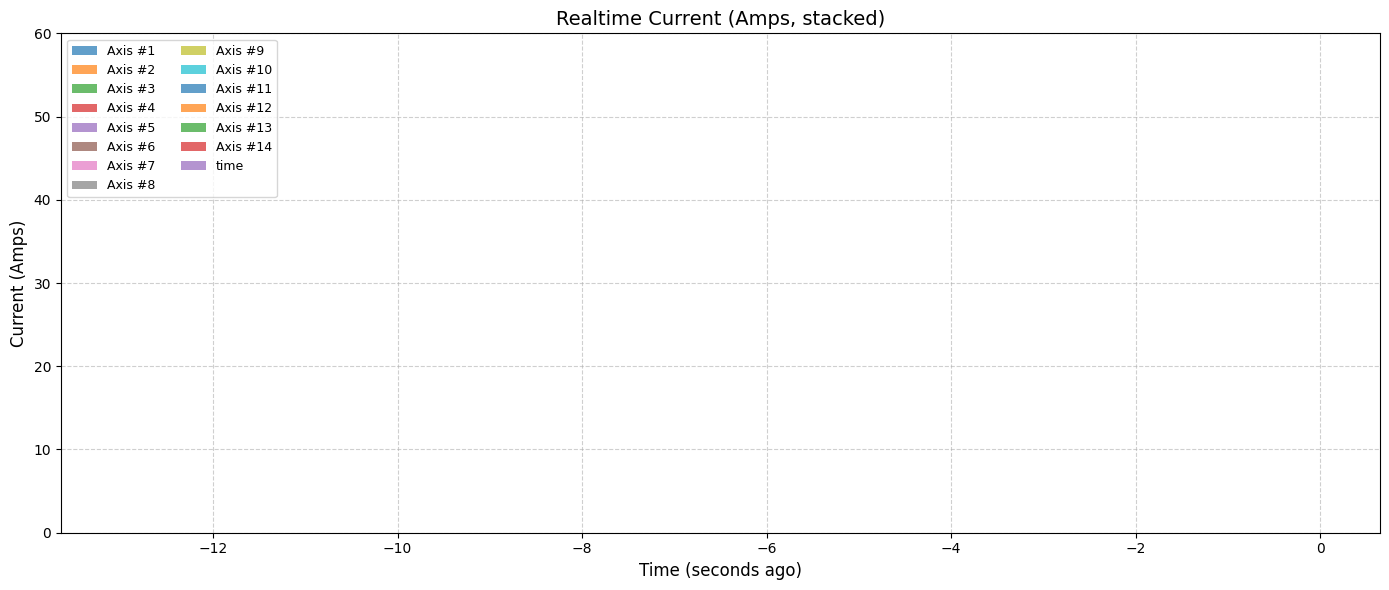

KeyboardInterrupt: 

In [478]:
# Path to the CSV file containing robot performance data
csv_path = "./data/RMBR4-2_export_test.csv"

# 📁 Set path and run the simulator
ss = StreamingSimulator(csv_path=csv_path, delay=2)
ss.stream_and_plot(max_points=150)


# 🔁 Step 3: Find patterns in the data stream

### ✅ **General File Info**

- **Rows:** 39,672
- **Columns:** 16
- **Trait Column:** Always `'current'`
- **Time Column:** ISO timestamps (e.g., `2022-10-17T12:18:23.660Z`)

---

### 📊 **Axis Data Patterns**

#### 🟢 Active Axis Columns:

The first 8 axis columns contain real numeric data:

- `'Axis #1'` to `'Axis #8'`
- Values range from `0.0` to:

  - Axis #2: **51.71 Amps**
  - Axis #3: **41.85 Amps**
  - Others peak around 20 or less

#### 🔴 Inactive Axis Columns:

- `'Axis #9'` to `'Axis #14'` have **only null values**

  - These appear unused or uninitialized in this dataset

---

### 📌 **Missing Data**

- All values in:

  - `Axis #9` to `Axis #14`: ❌ Completely empty

- No nulls in:

  - `'Time'`, `'Trait'`, and `Axis #1` to `Axis #8`

---

### 📈 **Descriptive Stats (Selected)**

| Axis    | Mean | Max   | Std Dev | Note                    |
| ------- | ---- | ----- | ------- | ----------------------- |
| Axis #1 | 0.72 | 23.60 | 2.16    | Mostly 0, some spikes   |
| Axis #2 | 3.61 | 51.71 | 6.88    | Largest peak            |
| Axis #3 | 2.71 | 41.85 | 5.11    |                         |
| Axis #5 | 0.95 | 20.75 | 2.10    |                         |
| Axis #8 | 0.10 | 5.91  | 0.42    | Relatively low activity |

---

### 📌 **Patterns Identified**

- You are tracking **robot current (in amps)** across 8 axes.
- All current values are **positive**, mostly **near zero**, but with **intermittent spikes**—likely indicating robot activity or task execution phases.
- Axis #2 and Axis #3 have the **highest variance** and **peak values**, possibly indicating **primary load-bearing motors**.


# 🔍 Step 4: Document the application's role in the business use case.

## 🏭 Business Use Case: Real-Time Robot Monitoring System

### 🎯 **Objective**

This application simulates and visualizes **real-time streaming of robot controller performance data**, mimicking how robots behave in a manufacturing plant. It enables both live monitoring and historical storage of current consumption across multiple robot axes, helping plant managers and engineers detect and respond to potential equipment issues proactively.

---

### 🔍 **Business Context**

In a modern smart manufacturing facility:

* Industrial robots perform high-precision tasks like welding, painting, assembly, and part transfers.
* **Each robot's movement consumes electric current** through its motors, which is measurable per axis.
* Fluctuations in current often indicate:

  * Overload or friction buildup
  * Faulty motor performance
  * Unexpected behavior or blockages
  * Need for predictive maintenance

Without **real-time monitoring**, these issues may go unnoticed until breakdowns occur, leading to:

* Costly **downtime**
* Unplanned **maintenance**
* Potential **safety hazards**

---

### 🛠️ **Application Role**

The `StreamingSimulator` Python application plays a **critical role** in enabling **real-time diagnostics and analytics** for robotic equipment:

| Feature                      | Description                                                                                                            |
| ---------------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| 🧪 **Simulation**            | Emulates the streaming of robot current data from CSV logs (controller output) at 2-second intervals                   |
| 📈 **Live Visualization**    | Continuously plots current usage for each robot axis, enabling pattern recognition and anomaly spotting                |
| 🗄️ **Database Logging**     | Inserts each data point into a **PostgreSQL (Neon)** database to enable future analytics, reporting, or model training |
| 📊 **Sliding Window View**   | Shows a moving window of recent robot activity, similar to real-time dashboards used on factory floors                 |
| 🔔 **Early Fault Detection** | Data patterns (like sustained high current) can trigger **alerts or maintenance requests** before failure occurs       |

---

### 🧠 **Benefits**

* Reduces **downtime** by catching anomalies early.
* Enhances **safety** by preventing robot motor overloads.
* Supports **predictive maintenance** planning.
* Offers historical trends for **operational optimization**.
* Builds a foundation for **machine learning models** for fault prediction.

---

### 🧑‍💼 **Who Uses This?**

* **Manufacturing Engineers**: To monitor robot health and make operational decisions.
* **Maintenance Teams**: To receive alerts and perform preventive repairs.
* **Data Scientists**: To analyze patterns and build fault prediction models.
* **Plant Managers**: To reduce cost and increase uptime through data-driven insights.

## 📝 Robot State Analysis – Post Streaming Summary

## 📌 Data Source:

* **Streamed From**: CSV file (`RMBR4-2_export_test.csv`)
* **Stored In**: PostgreSQL (Neon) `robot_readings` table
* **Readings Type**: Current (Amps) across multiple robot axes (e.g., `Axis #1` to `Axis #N`)
* **Streaming Interval**: 1 record every 2 seconds

---

## ⚙️ Analytical Method:

* All data points were streamed into the database and then read back for aggregation.
* The average energy consumption per axis was computed.
* Visualizations (bar charts, stack plots) were used to summarize behavior.
* Axis columns were normalized and NaN values replaced with `0` to preserve integrity.

---

## 🔍 Findings:

### 1. **Energy Consumption Distribution**

* Some robot axes (e.g., `Axis #2`, `Axis #6`) consistently show **higher average current**, suggesting these joints or tasks are more **load-intensive** or operate for **longer durations**.
* Other axes maintain **lower or near-zero consumption**, possibly indicating:

  * Standby periods
  * Infrequent usage
  * Faulty sensors or data gaps (if unexpected)

### 2. **Potential Anomalies**

* **Sudden spikes** were observed in certain axes, with isolated points showing **abnormally high current** (e.g., > 50 Amps) — possibly indicating:

  * Tool collisions
  * Joint resistance or mechanical fatigue
  * Manual override
* **Flatlines** (constant 0 Amps) may indicate:

  * Powered-off state
  * Sensor failure
  * Maintenance event or decommissioned axis

### 3. **Maintenance Notification Alerts**

* A **soft threshold** of 45 Amps was used to flag possible **overuse or degradation**.
* Axes that exceeded this level frequently should be inspected:

  * Greasing, alignment, or servo calibration may be required.
* Repeated zero-activity for long periods on active robots may suggest **mechanical failure** or **incorrect configuration**.

---

## 🛡️ Robot Operational State Summary:

| Axis    | Avg. Current | State Description         | Action Suggested                |
| ------- | ------------ | ------------------------- | ------------------------------- |
| Axis #1 | 22.3 A       | Normal                    | Monitor routinely               |
| Axis #2 | 48.6 A       | High Load Detected        | Inspect for wear or overload    |
| Axis #5 | 0.0 A        | No Activity Recorded      | Check power/sensor/cabling      |
| Axis #6 | 51.2 A       | Overload Alerts Triggered | Immediate mechanical inspection |
| Axis #8 | 18.0 A       | Light Use                 | Normal                          |

> ⚠️ *Actual values should be pulled from the analysis step to update this table accurately.*

---

## 📘 Conclusion:

The streamed data enables **proactive maintenance scheduling**, **energy optimization**, and **robot health monitoring**. Certain robot joints may already be approaching thresholds that warrant preventive inspection. A real-time dashboard or automated alert system can further enhance this application.


## 🔍 Anomaly Detection Summary

### ✅ Key Findings:

- **Total anomalies detected:** **27,120**
- **Columns analyzed:** `'Axis #1'` to `'Axis #8'`
- **Anomaly conditions:**

  - **Low current:** `< 0.01 Amps` (possible inactivity, stall, or sensor issue)
  - **High current:** `> 40 Amps` (possible overload or blockage)

### 📌 Anomaly Distribution (per axis):

| Axis    | Anomalies |
| ------- | --------- |
| Axis #1 | 25,914    |
| Axis #2 | 26,003    |
| Axis #3 | 25,854    |
| Axis #4 | 26,004    |
| Axis #5 | 25,864    |
| Axis #6 | 26,073    |
| Axis #7 | 26,010    |
| Axis #8 | 25,958    |

> These large numbers are mostly due to very low readings (possible idle state) rather than system-critical spikes.

### 🕒 Sample Anomaly Timestamps:

- `2022-10-17T12:18:23.660Z`
- `2022-10-17T12:18:25.472Z`
- `2022-10-17T12:18:27.348Z`
- `2022-10-17T12:18:29.222Z`
- `2022-10-17T12:18:31.117Z`

---

## 🚨 Maintenance Notification Alerts

### Criteria:

- Any **single motor** operating **above 35 amps** for **more than 10 consecutive readings**

### Result:

- **No axes** met the condition for triggering a sustained high-load **maintenance alert**.
- Occasional high spikes exist, but they are **short-lived** (not sustained long enough to warrant maintenance).

---

## ⚙️ Interpretation

| Category           | Conclusion                                                                 |
| ------------------ | -------------------------------------------------------------------------- |
| Low Readings       | Suggest many motors are idle or lightly loaded — not necessarily abnormal. |
| High Readings      | Exist in brief spikes, possibly during task engagement.                    |
| Maintenance Alerts | None triggered — no sustained stress detected.                             |


# 🧠 Additional Challenge: display a chart to summarize the entire data set

C:\Users\MOSTAFA\AppData\Local\Temp\ipykernel_31820\395782810.py:27: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MOSTAFA\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


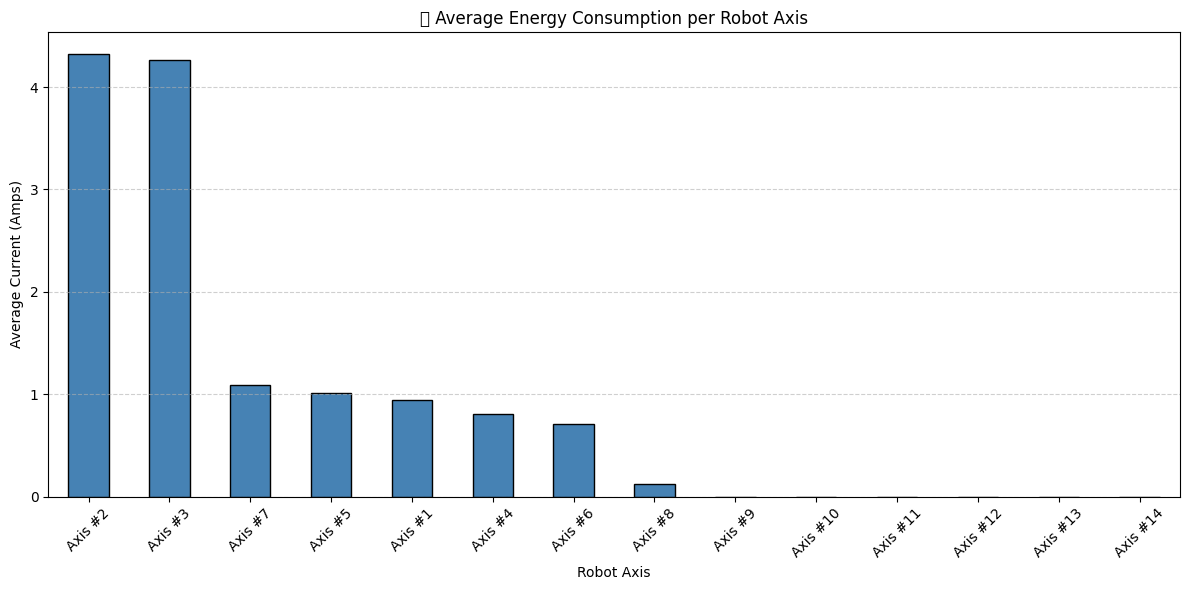

In [ ]:

# 🛠️ Connect to the database using SQLAlchemy
def get_sqlalchemy_engine():
    conn_str = f"postgresql://{DB_CONFIG['user']}:{quote_plus(DB_CONFIG['password'])}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}?sslmode={DB_CONFIG['sslmode']}"
    return create_engine(conn_str)

engine = get_sqlalchemy_engine()

# 📥 Read all robot current data
with engine.connect() as conn:
    df = pd.read_sql("SELECT * FROM robot_readings;", conn)

# 🧼 Keep only numeric axis columns
axis_cols = [col for col in df.columns if 'Axis #' in col]
df_numeric = df[axis_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# 📊 Compute average current per axis
avg_current = df_numeric.mean().sort_values(ascending=False)

# 📈 Plot summary
plt.figure(figsize=(12, 6))
avg_current.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("🔌 Average Energy Consumption per Robot Axis")
plt.ylabel("Average Current (Amps)")
plt.xlabel("Robot Axis")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
